In [70]:
# import libraries
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms as T
from torch.utils.data import DataLoader, Subset, TensorDataset, SubsetRandomSampler
from torchvision.datasets import FashionMNIST

import torchvision

import sys

import matplotlib.pyplot as plt

import tqdm

import pandas as pd

from typing import Sequence, Tuple, Optional, List

In [71]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Import and Process Data

In [86]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = FashionMNIST(root='./data', train=True,  download=True, transform=transform)

selections = ['Trouser','Sneaker','Pullover']

# Select classes and build indices using raw labels
selections = ['Trouser','Sneaker','Pullover']
selected_idx = {trainset.class_to_idx[c] for c in selections}


# FashionMNIST stores labels in .targets (tensor of shape [60000])
mask = torch.isin(trainset.targets, torch.tensor(list(selected_idx)))
subset_indices = torch.nonzero(mask, as_tuple=False).squeeze(1)

# Wrap the original dataset so transforms are preserved
train_small = Subset(trainset, subset_indices)

# transform to dataloaders
batchsize    = 1024
train_loader = DataLoader(train_small, # Use train_small here
                          batch_size=batchsize,
                          shuffle=True,
                          drop_last=True,
                          num_workers=max(2,os.cpu_count()//2),
                          pin_memory=True,
                          persistent_workers=True,
                          prefetch_factor=2
                          )

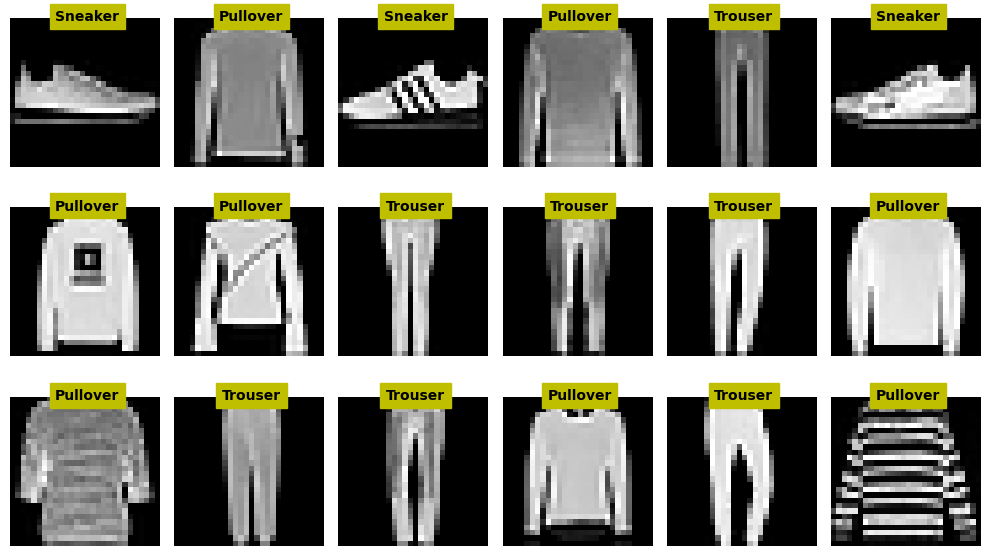

In [87]:
# view some images
# inspect a few random images

X,y = next(iter(train_loader))

fig,axs = plt.subplots(3,6,figsize=(10,6))

for (i,ax) in enumerate(axs.flatten()):

  # extract that image
  pic = torch.squeeze(X.data[i])
  pic = pic/2 + .5 # undo normalization

  # and its label
  label = trainset.classes[y[i]]

  # and show!
  ax.imshow(pic,cmap='gray')
  ax.text(14,0,label,ha='center',fontweight='bold',color='k',backgroundcolor='y')
  ax.axis('off')

plt.tight_layout()
plt.show()

# Build the Models

In [88]:
# Build discriminator models
class discriminatorNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(28*28,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,1)

  def forward(self,x):
    x = x.view(x.size(0),-1) # Convert from (B,C,H,W) -> (B,C*H*W)
    x = F.leaky_relu( self.fc1(x), negative_slope=0.2 )
    x = F.leaky_relu( x )
    x = F.leaky_relu( self.fc2(x), negative_slope=0.2 )
    x = self.out(x)
    return torch.sigmoid( x )

In [89]:
dnet = discriminatorNet()
y = torch.randn(10,28*28)
yHat = dnet(y)
print(yHat.shape)

torch.Size([10, 1])


In [90]:
# Build Generator model
class generatorNet(nn.Module):
  def __init__(self, nz=64):
    super().__init__()

    self.fc1 = nn.Linear(nz,256)
    self.fc2 = nn.Linear(256,256)
    self.out = nn.Linear(256,784)

  def forward(self,x):
    x = F.leaky_relu( self.fc1(x), negative_slope=0.2 )
    x = F.leaky_relu( self.fc2(x), negative_slope=0.2 )
    x = self.out(x)
    return torch.tanh( x )

In [91]:
gnet = generatorNet()
y = torch.randn(10,64)
yHat = gnet(y)
print(yHat.shape)

torch.Size([10, 784])


# Train the model

In [92]:
device

device(type='cuda', index=0)

In [93]:
# loss function (same for both phases of training)
lossfun = nn.BCELoss()

# create instances of the models and load them to GPU
dnet = discriminatorNet().to(device)
gnet = generatorNet(nz=64).to(device)

# optimizers (same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(dnet.parameters(), lr=.0003)
g_optimizer = torch.optim.Adam(gnet.parameters(), lr=.0003)

In [94]:
print("dnet on:", next(dnet.parameters()).device)
print("gnet on:", next(gnet.parameters()).device)

dnet on: cuda:0
gnet on: cuda:0


In [95]:
X,_ = next(iter(train_loader))
X.shape

torch.Size([1024, 1, 28, 28])

In [96]:
from torch.cuda.amp import autocast, GradScaler
import time

 # ---------- AMP (new API); enable only on CUDA ----------
use_cuda = (device.type == "cuda")
scaler = torch.amp.GradScaler(enabled=use_cuda)

num_epochs = 50000//batchsize
nz = 64

losses  = np.zeros((num_epochs,2))

# Time Logging
start_time = time.time()

for epochi in range(num_epochs):

    for X, _ in train_loader:
        X = X.float().to(device, non_blocking=True) # Move the input data to the device

        # ------------------ Train Discriminator ------------------
        dnet.train()
        gnet.eval()

        real_labels = torch.ones(batchsize,1,device=device)
        fake_labels = torch.zeros(batchsize,1,device=device)

        # real
        d_optimizer.zero_grad(set_to_none=True)

        logits_real = dnet(X)
        d_loss_real = lossfun(logits_real, real_labels)

        # fake
        z = torch.randn(batchsize, nz, device=device)

        with torch.no_grad():
          fake = gnet(z)

        logits_fake = dnet(fake)
        d_loss_fake = lossfun(logits_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake

        # backprop for Discrminator batch
        if use_cuda:
          scaler.scale(d_loss).backward()
          scaler.step(d_optimizer)
          scaler.update()
        else:
          d_loss.backward()
          d_optimizer.step()

        # ------------------ Train Generator ------------------
        dnet.eval()
        gnet.train()

        g_optimizer.zero_grad(set_to_none=True)


        # fake
        z = torch.randn(batchsize, nz, device=device)
        fake = gnet(z)
        logits_fake_for_g = dnet(fake)             # D’s judgment on fake
        g_loss = lossfun(logits_fake_for_g, real_labels)  # want D to say "real"

        # backprop
        if use_cuda:
          scaler.scale(g_loss).backward()
          scaler.step(g_optimizer)
          scaler.update()
        else:
          g_loss.backward()
          g_optimizer.step()

    # epoch logs
    losses[epochi, 0]  = d_loss.item()
    losses[epochi, 1]  = g_loss.item()

    elapased_time = time.time() - start_time

    mins, secs = divmod(elapased_time, 60)
    hours, mins = divmod(mins, 60)

    if (epochi + 1) % 100 == 0:
        sys.stdout.write(
            f"\nEpoch {epochi+1}/{num_epochs} | "
            f"D: {losses[epochi,0]:.3f} | G: {losses[epochi,1]:.3f} | "
            f"\t time: {int(hours):2d}:{int(mins):2d}:{int(secs):2d} (h:m:s)"
        )

In [97]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [98]:
print(f'Discriminator Loss Range: {losses[:,0].min():.3f} to {losses[:,0].max():.3f}')
print(f'Generator Loss Range: {losses[:,1].min():.3f} to {losses[:,1].max():.3f}')

Discriminator Loss Range: 0.027 to 1.177
Generator Loss Range: 0.582 to 7.047


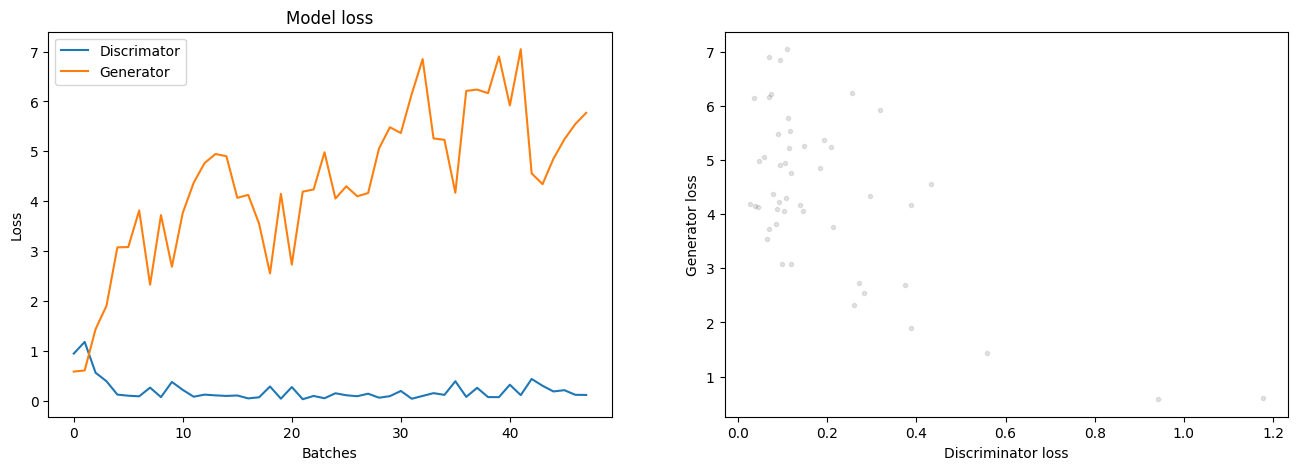

In [99]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses[:,0])
ax[0].plot(losses[:,1])
ax[0].set_xlabel('Batches')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].legend(['Discrimator','Generator'])
# ax[0].set_xlim([4000,6000])

ax[1].plot(losses[:,0],losses[:,1],'k.',alpha=.1)
ax[1].set_xlabel('Discriminator loss')
ax[1].set_ylabel('Generator loss')

plt.show();

# Visualize the fake data

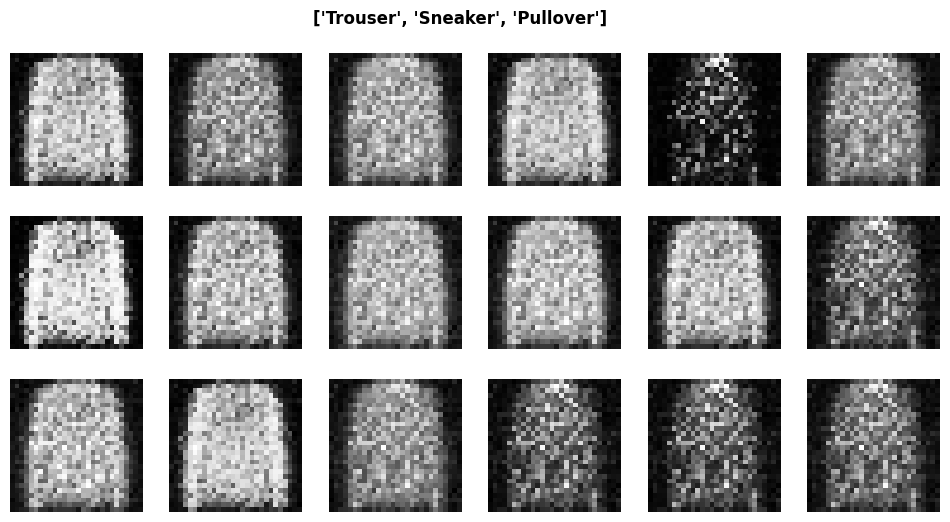

In [100]:
# generate the images from the generator network
gnet.eval()
fake_data = gnet(torch.randn(18,64).to(device)).cpu()

# and visualize...
fig,axs = plt.subplots(3,6,figsize=(12,6))
for i,ax in enumerate(axs.flatten()):
  ax.imshow(fake_data[i,:,].detach().view(28,28),cmap='gray')
  ax.axis('off')

plt.suptitle(selections,y=.95,fontweight='bold')
plt.show();